# Layered Model Starter Code

## Model Description 
This is a steady state, layered box model with recharge.

#### Dimensions: 
- 50 by 50 by 1
- dx = dy = 100 m
- dz = 100 m  

#### Topography
- Land surface 100m above the datum on the left hand side
- sloping linearly to 85m above the datum on the right hand side

#### Subsurface Properties: 
- Homogeneous 
- K = 1.0 m/day in x and y and 0.1 m/day in z.  
- Porosity = 0.35
- Specific yield = 0.3
- Storage coefficient=0.001  

#### Boundary Conditions: 
 - Left boundary constant head 85m
 - Right boundary is a constant head of 70m 
 - Recharge occurs at a rate of 5E-5 m/d uniformly across the domain
 
#### Well: 
 - Pumping well
     - Located at (2500, 2500)
     - Pumping at a rate of 500 m^3/day 

#### Layered Scenario
 - Low K layer - Kx=Ky=Kz=0.0001m/d
 - Extends from 25-35m above the base of the domain
 - The well is only completed in the lowest layer
     

## Set Up Environment

In [747]:
#the basics
import flopy
import numpy as np
import matplotlib as mp
import pandas as pd
import os

#additional analysis tools
import flopy.utils.binaryfile as bf
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import csv

#jupyter specific--included to show plots in notebook
%matplotlib inline 



# Topography Set up

In [748]:
# original Z top
with open('BASE_top_elev.csv', 'r', encoding='utf-8-sig') as reader: 
    # this reads the csv in as an array
    ztop = np.genfromtxt(reader, dtype=float, delimiter=',') # top elevation of top layer (import from csv file) (dim: nrow,ncol)

zbot = 0.     #bottom elevation


dz_num = (ztop- zbot) #cell height in z direction

## All Input Variables

In [749]:
## model directory
moddir="/Applications/MODFLOW/mf2005"

## Discretization
nrow = 50 #number of rows
ncol = 50 #number of columns
nlay = 3  #number of layers

dx= 1000 #width of grid cells in x direction 
dy= 1000 #width of grid cells in y direction 

Lx = ncol*dx  #width of domain in x
Ly = nrow*dy #width of domain in y

# create new file and link it here for challenge Q 4 
# Add code to change this in a new Jupyter block
dz = dz_num/nlay

## Timing
nper = 1 #number of stress periods 
steady = [True] #list noting the stress period type

## Subsurface properties
K_horiz = 8.5    #assign horizontal hydraulic conductivity 
K_vert = 8.5   #assign vertical hydraulic conductivity (along z axis)

# Define Layer Properties for LPF Files
ss = np.ones((nlay,nrow,ncol), dtype=np.float)        #define specific storage
ss[:,:,:] = 0.0001 #assign storage coefficient
n = 0.1        #assign porosity   
Sy = 0.1        #assign specific yield
uncnf = 1       #0=confined, >0 = unconfined


## Recharge
recharge_all = 4e-5 #m/day


## Boundary conditions

h_right = 70

/opt/miniconda3/envs/gwnew37/lib/python3.7/site-packages/ipykernel_launcher.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


## Baseline Scenario with Pumping and Agriculture Off

In [750]:
#Initialize the model
modelname1 = "NANT"

m1 = flopy.modflow.Modflow(modelname1, exe_name = moddir)

botm = np.zeros((nlay,nrow,ncol)) # initialize array of zeros for bottom elevation for each model cell (dim: nlay,nrow,ncol)
botm[1,:,:] = 40.                  # bottom elevation of middle layer (1) is 25 m
botm[0,:,:] = 45.                  # bottom elevation of top layer (0) is 35 m 

## Make a arrays for the K values
Kz = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kz[:,:,:] = K_vert                   # assign the original value to the entire array
Kz[1,:,21:50] = 0.0001                 # Replace the K in the middle layer with the lower value

Kh = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kh[:,:,:] = K_horiz                  # assign the original value to the entire array

#Discretization - dis
dis = flopy.modflow.ModflowDis(model=m1, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=botm, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady)

# Boundary and initial conditions - bas
#Define cell activity (IBOUND)
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32) #integer array of dim (z,y,x), makes all cells active                                                     
ibound[:,:,49] = -1         #replace rightmost column (all zs, all ys, first x) with -1 to indicate constant head
ibound[:,:,0] = 0

# Top Left Corner
# layer One
ibound[:,0,0:6] = 0
ibound[:,1,0:5] = 0
ibound[:,2,0:4] = 0
ibound[:,3, 0:3] = 0
ibound[:, 4, 0:2] = 0
ibound[:,5, 0:1] = 0


#Layer 2
ibound[1,0, 0:7]= 0
ibound[1, 1, 0:6] =0
ibound[1,2, 0:5] = 0
ibound[1,3, 0:4] = 0
ibound[1,4, 0:3] = 0
ibound[1,5, 0:2] = 0
ibound[1,6, 0:1] =0
ibound[1,7,0] =1

#Layer 3
ibound[2,0,5:10] = 0
ibound[2,1,4:9] = 0
ibound[2,2,3:8] = 0
ibound[2,3, 2:7] = 0
ibound[2, 4, 1:6] = 0
ibound[2,5, 0:5] = 0
ibound[2,6, 0:4] = 0
ibound[2,7, 0:3] = 0
ibound[2,8, 0:2] = 0
ibound[2,9, 0:1] = 0
ibound[2,10, 0] = 0

# Bottom Left
# layer One
ibound[:,49,0:6] = 0
ibound[:,48,0:5] = 0
ibound[:,47,0:4] = 0
ibound[:,46, 0:3] = 0
ibound[:, 45, 0:2] = 0
ibound[:,44,0] = 0

#Layer 2
ibound[1, 49, 0:7] = 0
ibound[1,48, 0:6] = 0
ibound[1,47, 0:5] = 0
ibound[1,46, 0:4] = 0
ibound[1,45, 0:3] = 0
ibound[1,44, 0:2] = 0
ibound[1,43, 0:1] = 0
ibound[1,42, 0] = 0

#Layer 3
ibound[2,49,5:10] = 0
ibound[2,48,4:9] = 0
ibound[2,47,3:8] = 0
ibound[2,46, 2:7] = 0
ibound[2, 45, 1:6] = 0
ibound[2,44, 0:5] = 0
ibound[2,43, 0:4] = 0
ibound[2,42, 0:3] = 0
ibound[2,41, 0:2] = 0
ibound[2,40, 0:1] = 0

## Other Boundaries are no flow so we make all those cells inactive
ibound[:,0, :] = 0
ibound[:,-1, :] = 0

#setup initial heads as 1 everywhere except on the boundaries
H_init = np.ones((nlay, nrow, ncol), dtype=np.float32)  #float array (i.e. decimal), sets all heads to 1.0
H_init[:, :, :] = h_right    #initialize the entire domain to the right head value

bas = flopy.modflow.ModflowBas(m1, ibound=ibound, strt=H_init)

#Layer properties - lpf
lpf = flopy.modflow.ModflowLpf(m1, laytyp=uncnf, hk=K_horiz, 
                               vka=K_vert, ss=ss,
                               sy=Sy,storagecoefficient=True, ipakcb=53) 

#Recharge 
rech_zone = np.zeros((nrow,ncol))  #define an array of zeros of dim (nrow,ncol)
rech_zone[:,0:16]=recharge_all
#print(rech_zone)
rch = flopy.modflow.mfrch.ModflowRch(model=m1, rech=rech_zone, ipakcb=53)  #create rch object

#ET Object
ET_zone = np.zeros((nrow,ncol))     # define an array of zeroes the size of the model grid
riv_et = 5e-4  #set background ET value m/day
back_et = 1e-5
ET_zone[:, 25:49] = ET_zone[:, 25:49] +back_et
ET_zone[22:29,:] = ET_zone[22:29,:] + riv_et  #apply riv et to the right section
extinction_depth = 1

evt = flopy.modflow.mfevt.ModflowEvt(model=m1, surf=ztop, evtr=ET_zone, exdp=extinction_depth, ipakcb=53) 


#Output control - OC 
spd = {(0,0):['print head', 'print budget', 'save head', 'save budget']} #create a dictionary for stress period data, where key (0,0) is associated with value ['print...'] 
oc = flopy.modflow.ModflowOc(model=m1, stress_period_data=spd, compact=True)

#Numerical solver - pcg
pcg = flopy.modflow.ModflowPcg(model=m1)

# Streambed thickness and width do not necessarily align with the grid cell values
# This package is a head dependent flux package!
# User inputs:
k_strbott = 10                  #river bottom hydraulic conductivity in f/d
sed_thick = 1                      #thickness of riverbed sediment in f
str_bott = 1                      #river bottom
slope = 0.001                        #slope of streambed (m/m)
rough = 0.04                         #roughness of streambed
width = 1                           #x-sectional width of channel (m)
Flow_into_the_1st_reach = 0    # m^3/day
Stage_above_datum = 0.5 # m^3/day; top of streambed is at 8 m (incl 1 m of streambed thickness)

# str settings
set_icalc = 1                   #1 if the stage is to be calculated based on flow, otherwise specify below
str_spd1 = []                      #create list to store all river cells for stress period 1
const = 86400.0                      #multiplication constant for m3/day - see documentation for other units
istcb2 = 53                          #save outflows to cbb file

# calculated values
cond = k_strbott*(width)*(dy)/(sed_thick)  #river bed conductance in f^2/d
cond_vals = np.ones(nrow) * cond

str_top = str_bott+sed_thick
str_stage = Stage_above_datum

if set_icalc > 0:      #Calculating the stage for graphing using Manning formula
    str_stage = str_top + ((Flow_into_the_1st_reach*rough)/(const*width*(slope**0.5)))**0.6   
    #print("Calculated stage at inflow =", str_stage)

#Adding str package with only 1 stress period and one segment
# Has to be a loop because we need to have all these values for each reach (ie each grid cell)!
strd = {}  
strspd = []
for x in range(ncol): # should loop from 0 to 49
    add = [0, 25, x, 1, x+1, Flow_into_the_1st_reach, str_stage, cond_vals[x], str_bott, str_top, width, slope, rough]
    strspd.append(add)
strd[0]=strspd  
#print(strspd)
 
# Will need to have two segments in the next HW because we have recharge happening into the river from the farm..... yay!
seg_info = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   #create segment info array - all zeros since only one segment
str_segd = {0: seg_info}                       #create dict of segment info keyed to stress periods

strm = flopy.modflow.mfstr.ModflowStr(m1, mxacts=75, nss=1, ntrib=0, ndiv=0,icalc= set_icalc, const=const, ipakcb=53,  istcb2=istcb2, dtype=None,
         stress_period_data=strd, segment_data=str_segd, extension='str') 
#write the inputs

m1.write_input()    

#Run the model 
success, mfoutput = m1.run_model(pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')


FloPy is using the following executable to run the model: /Applications/MODFLOW/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: NANT.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2022/04/19 13:19:43

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2022/04/19 13:19:43
 Elapsed run time:  0.097 Seconds

  Normal termination of simulation


# Yes Town and No Agriculture Scenario

In [764]:
#Initialize the model
modelname2 = "NAYT"
m2 = flopy.modflow.Modflow(modelname2, exe_name = moddir)

#Discretization - dis
# no changes because we have the base case working
dis = flopy.modflow.ModflowDis(model=m2, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=botm, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady)


# Boundary and initial conditions - bas
bas = flopy.modflow.ModflowBas(m2, ibound=ibound, strt=H_init)

#Layer properties - lpf
lpf = flopy.modflow.ModflowLpf(m2, laytyp=uncnf, hk=K_horiz, 
                               vka=K_vert, ss=ss,
                               sy=Sy,storagecoefficient=True, ipakcb=53) 


#Recharge 
#rch = flopy.modflow.mfrch.ModflowRch(model=m2, rech=rech_zone, ipakcb=53)  #create rch object


evt = flopy.modflow.mfevt.ModflowEvt(model=m2, surf=ztop, evtr=ET_zone, exdp=extinction_depth, ipakcb=53) 

#Output control - OC 
spd = {(0,0):['print head', 'print budget', 'save head', 'save budget']} #create a dictionary for stress period data, where key (0,0) is associated with value ['print...'] 
oc = flopy.modflow.ModflowOc(model=m2, stress_period_data=spd, compact=True)

#Numerical solver - pcg
pcg = flopy.modflow.ModflowPcg(model=m2)

#Town Well
# well location is in the bottom of the domain initially
well_loc = (2,21,28) #Well loc should be layer, row, column
Q_in = -1500                       # Volumetric flux from the well in units of L3/T 
fluxes = [0,21,28,Q_in]

sp_fluxes = {0: fluxes}              #create a dictionary with entries for each stress period

wel = flopy.modflow.ModflowWel(model=m2, stress_period_data=sp_fluxes)

# Set Up Stream Stuff
#1. Setup the stream characteristics 
nseg = 3
ntrib = 2
slope = 0.001  #slope of streambed (m/m)
rough = 0.04 #roughness of streambed
width = 1. #x-sectional width of channel (m)
Flow_into_the_1st_reach = 0 # m^3/day
set_icalc = 1  # the stage is to be calculated based on flow
const = 86400.0 #multiplication constant for m3/day 

# 2. Calculate the streambed conductance 
k_strbott = 10  #river bottom hydraulic conductivity in l/t
sed_thick = 1 #thickness of riverbed sediment 
cond = k_strbott*(width)*(dy)/(sed_thick) 

#3. Setup the reach locations stream segment numbers and reach numbers
#(Note we are taking a slightly more complicated approach here setting the streambed relative to the elevation of the land surface)
#Setup the reach locations – here the row value will be 25 for each reach and the column values will go from 0-49
nreach =  50   # river extending the width of the domain
str_rows = 25*np.ones((nreach),dtype=np.int32)  # integer array of row #s for each reach 
# THIS MIGHT NEED TO BE 49
str_cols = np.arange(0,nreach)  # integer array of col #s for each reach 

#Setup the inflows for the reaches
Qreturn =50     # return flow from the town
return_loc = 25    #specifying the column where the town return flows come in
reach_flow = np.zeros((nreach),dtype=np.int32)  # initially set all inflows to zero for all reaches
reach_flow[return_loc] = Qreturn # inflow to seg2 = return from town
reach_flow[return_loc+1] = -1 # inflow to seg3 = sum of all previous segs

#setup segment numbers – this is a list of segment values that goes with each reach
segments = np.ones((nreach),dtype=np.int32)    # make a segment array that is nreach long and initialize all the values to 1
segments[return_loc] = 2    #Change the segment number to ‘2’ where the town recharge comes in
segments[return_loc+1:nreach] = 3    # Change the segment number to ‘3’ everywhere downstream of the the town well


#setup reach numbers – this will be the numbering of the reaches within each segment. 
# Recall that numbering starts and one and increases moving downstream
reaches = np.arange(1,nreach+1)   # create an array of reach #s counting from 1-50
reaches[return_loc] = 1    # reassign the reach number to be 1 for segment 2
reaches[return_loc+1:nreach] = np.arange(1,nreach-(return_loc+1)+1)  # reassign the reach numbers for segment 3 to start counting at 1

#ztop = np.genfromtxt('BASE_top_elev.csv', delimiter=',') # top elevation of top layer (import from csv file) (dim: nrow, ncol)
surf_elev = np.zeros((nreach))   # create array of zeros the length of the stream

# loop over the stream reaches and pull the land surface elevation for the location of each stream cell
# walking along row 25 and adding elevation to each
for i in np.arange(nreach): 
      surf_elev[i] = ztop[str_rows[i],str_cols[i]]

Stop = surf_elev -  1.    # elevation of the top of the streambed (1 m below land surface) (m)
Sbot = Stop - sed_thick      # elevation of the bottom of the streambed (m)
stage_elev = Stop + str_stage      # elevation of the water surface in the stream (m)

#Setup the stress period dictionary
str_info = np.zeros((nreach,13)) # create array of zeros for reaches, each reach requires 13 input values

# Loop over the reaches and setup the data
# DOUBLE CHECK THIS ORDER TO MAKE SURE IT'S THE RIGHT ORDER!
for r in np.arange(nreach): 
     str_info[r,:] = [0, str_rows[r], str_cols[r], segments[r], reaches[r], reach_flow[r], stage_elev[r], cond, Sbot[r], Stop[r], width,  slope, rough]
str_spd = {0: str_info} # save the stream info in a stress period dictionary


#Setup the segments dictionary
#for each segment, need an array of 10 zeros, for last segment, first two values are seg #s of upstream segments

seg_info = np.zeros((10,nseg))
seg_info = [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1]]
str_segd = {0: seg_info}  #save the stream info in a segment dictionary

#Setup the mudflow package call
strm = flopy.modflow.mfstr.ModflowStr(m2, mxacts=nreach, nss=nseg, ntrib=ntrib, ndiv=0,icalc=set_icalc, const=const, ipakcb=53, istcb2=53, dtype=None, stress_period_data=str_spd, segment_data=str_segd, extension='str')
# strm = flopy.modflow.mfstr.ModflowStr(m1, mxacts=75, nss=1, ntrib=0, ndiv=0,icalc= set_icalc, const=const, ipakcb=53,  istcb2=istcb2, dtype=None,
#          stress_period_data=strd, segment_data=str_segd, extension='str') 

#write the inputs
m2.write_input()    

#Run the model 
success, mfoutput = m2.run_model(pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')

FloPy is using the following executable to run the model: /Applications/MODFLOW/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: NAYT.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2022/04/19 13:36:03

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2022/04/19 13:36:03
 Elapsed run time:  0.111 Seconds

  Normal termination of simulation


# Yes Agriculture and Yes Town Scenario

In [765]:
# Gather Packages and Such for the Town and Agriculture Scenario
modelname3 = "YAYT"
m3 = flopy.modflow.Modflow(modelname3, exe_name = moddir)

#Discretization - dis
# no changes because we have the base case working
dis = flopy.modflow.ModflowDis(model=m3, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=botm, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady)


# Boundary and initial conditions - bas
bas = flopy.modflow.ModflowBas(m3, ibound=ibound, strt=H_init)

#Layer properties - lpf
lpf = flopy.modflow.ModflowLpf(m3, laytyp=uncnf, hk=K_horiz, 
                               vka=K_vert, ss=ss,
                               sy=Sy,storagecoefficient=True, ipakcb=53) 


#Recharge 
recharge_farm = 0.0012
rech_zone[:,0:15]=recharge_all
rech_zone[21:23,19:21] = recharge_farm
rch = flopy.modflow.mfrch.ModflowRch(model=m3, rech=rech_zone, ipakcb=53)  #create rch object

#ET
ET_zone[:, 25:49] = ET_zone[:, 25:49] +back_et
ET_zone[22:29,:] = ET_zone[22:29,:] + riv_et  #apply riv et to the right section
ET_zone[21:23,19:21] = 0 # ET on the farm is 0
evt = flopy.modflow.mfevt.ModflowEvt(model=m3, surf=ztop, evtr=ET_zone, exdp=extinction_depth, ipakcb=53) 


#Output control - OC 
spd = {(0,0):['print head', 'print budget', 'save head', 'save budget']} #create a dictionary for stress period data, where key (0,0) is associated with value ['print...'] 
oc = flopy.modflow.ModflowOc(model=m3, stress_period_data=spd, compact=True)

#Numerical solver - pcg
pcg = flopy.modflow.ModflowPcg(model=m3)

# Wells
 # town well
Q_in1 = -1500                       # Volumetric flux from the well in units of L3/T 
fluxes1 = [0,21,28,Q_in1]

# farm well
Q_in2 = -0.003*(1/8)
fluxes2 = [0,12,14,Q_in2]
sp_fluxes = {0: fluxes1, 0: fluxes2} 
wel = flopy.modflow.ModflowWel(model=m3, stress_period_data=sp_fluxes)

#Stream Reaches for Town
strm = flopy.modflow.mfstr.ModflowStr(m2, mxacts=nreach, nss=nseg, ntrib=ntrib, ndiv=0,icalc=set_icalc, const=const, ipakcb=53, istcb2=53, dtype=None, stress_period_data=str_spd, segment_data=str_segd, extension='str')


# Agriculture Farm Scenario
# Farm is located  at 21 - 22 and 19 - 20 for the irrigated area

#write the inputs
m3.write_input()    

#Run the model 
success, mfoutput = m3.run_model(pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')


FloPy is using the following executable to run the model: /Applications/MODFLOW/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: YAYT.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2022/04/19 13:36:54

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2022/04/19 13:36:54
 Elapsed run time:  0.120 Seconds

  Normal termination of simulation


# 5. Plot the domains
### 5.1 Plan view of the domain

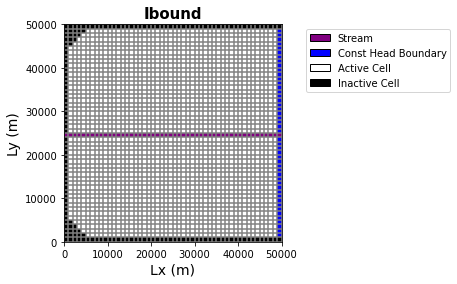

In [753]:
modelmap = flopy.plot.PlotMapView(model=m1, layer=0)
grid = modelmap.plot_grid()
ib = modelmap.plot_ibound()
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Ibound', fontsize = 15, fontweight = 'bold')
#wel_m = modelmap.plot_bc("WEL")
str_m = modelmap.plot_bc("STR")
plt.legend(handles=[mp.patches.Patch(color='purple',label='Stream',ec='black'),
                   mp.patches.Patch(color='blue',label='Const Head Boundary',ec='black'),
                   mp.patches.Patch(color='white',label='Active Cell',ec='black'),
                   mp.patches.Patch(color='black',label='Inactive Cell',ec='black')],
                   bbox_to_anchor=(1.8,1.0))
plt.show(modelmap)

### 5.2 Cross section of the layered model
For more examples of cross section plotting check out this notebook: https://github.com/modflowpy/flopy/blob/develop/examples/Notebooks/flopy3.3_PlotCrossSection.ipynb 

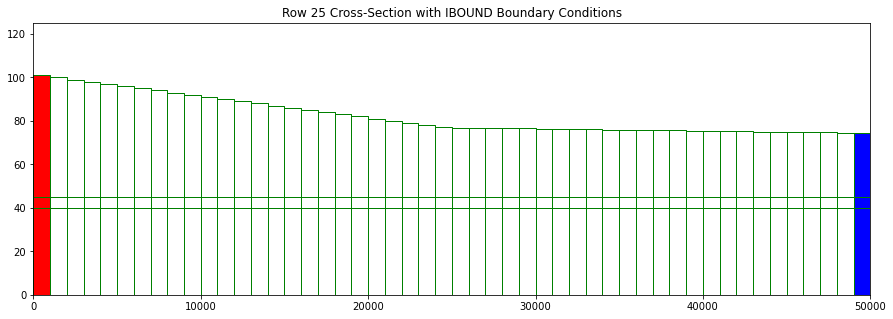

In [754]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)

# location of 0,0 is the MODFLOW LOCATION!
xsect = flopy.plot.PlotCrossSection(model=m1, line={'row': 24}) #note use the key 'column' if you want to plot a column instead
patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
#patches = xsect.plot_bc('WEL', color='red')
linecollection = xsect.plot_grid(color='green')
t = ax.set_title('Row 25 Cross-Section with IBOUND Boundary Conditions')



# 7. Read in the outputs

### 7.1 Modflow outputs - Heads and budget files

In [755]:
# Head - 1 layer model 
headobj1 = bf.HeadFile(modelname1+'.hds')    #reads the binary head file
times = headobj1.get_times()                 #returns a list of timesteps
head1 = headobj1.get_data(totim=times[-1])   #returns a numpy array of heads for specified time (last timestep)

#Head - 3 layer model 
headobj3 = bf.HeadFile(modelname3+'.hds')    #reads the binary head file
times = headobj3.get_times()                 #returns a list of timesteps
head3 = headobj3.get_data(totim=times[-1])   #returns a numpy array of heads for specified time (last timestep)


#Water balance - 1 layer
budgobj1 = bf.CellBudgetFile(modelname1+'.cbc')   #reads the cell budget file    
print(budgobj1.get_unique_record_names())
kstpkper_list1 = budgobj1.get_kstpkper()          #returns a list of stress periods & timesteps
frf1 = budgobj1.get_data(text='flow right face', totim=1.0) #returns an array of flow rates for right face of cells
fff1 = budgobj1.get_data(text='flow front face', totim=1.0) #returns an array of flow rates for front face of cells 
recharge1 = budgobj1.get_data(text='RECHARGE', totim=1.0) 


#Water balance - 3 layer
budgobj3 = bf.CellBudgetFile(modelname3+'.cbc')   #reads the cell budget file    
print(budgobj3.get_unique_record_names())
kstpkper_list3 = budgobj1.get_kstpkper()          #returns a list of stress periods & timesteps
frf3 = budgobj3.get_data(text='flow right face', totim=1.0) #returns an array of flow rates for right face of cells
fff3 = budgobj3.get_data(text='flow front face', totim=1.0) #returns an array of flow rates for front face of cells 
recharge3 = budgobj3.get_data(text='RECHARGE', totim=1.0) 
print(len(frf3))

[b'   CONSTANT HEAD', b'FLOW RIGHT FACE ', b'FLOW FRONT FACE ', b'FLOW LOWER FACE ', b'              ET', b'        RECHARGE', b'  STREAM LEAKAGE', b'STREAM FLOW OUT ']
[b'   CONSTANT HEAD', b'FLOW RIGHT FACE ', b'FLOW FRONT FACE ', b'FLOW LOWER FACE ', b'              ET', b'        RECHARGE']
1


# 8. Plotting
### 8.1 Cross section plots

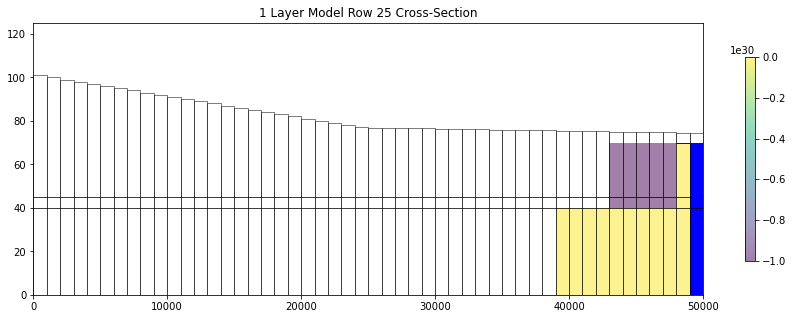

In [756]:
#### 1 layered model 
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)

xsect = flopy.plot.PlotCrossSection(model=m1, line={'row': 24}) #note use the key 'column' if you want to plot a column instaed
pc = xsect.plot_array(head1, masked_values=[999.], head=head3, alpha=0.5)
patches = xsect.plot_ibound(head=head1)
#patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
#patches = xsect.plot_bc('WEL', color='red')
linecollection = xsect.plot_grid(color='black', lw=0.5)
t = ax.set_title('1 Layer Model Row 25 Cross-Section')
cb = plt.colorbar(pc, shrink=0.75)
#Overlay the head in a layer of the model- in this case I'm doing the top layer i.e. head3[0,:,:]
wt = xsect.plot_surface(head1[0,:,:], masked_values=[999.], color='blue', lw=1)


# #### 3 layered model 
# fig = plt.figure(figsize=(15, 5))
# ax = fig.add_subplot(1, 1, 1)

# xsect = flopy.plot.PlotCrossSection(model=m3, line={'row': 24}) #note use the key 'column' if you want to plot a column instaed
# pc = xsect.plot_array(head3, masked_values=[999.], head=head3, alpha=0.5)
# patches = xsect.plot_ibound(head=head3)
# #patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
# #patches = xsect.plot_bc('WEL', color='red')
# linecollection = xsect.plot_grid(color='black', lw=0.5)
# t = ax.set_title('3 Layer Model Row 25 Cross-Section')
# cb = plt.colorbar(pc, shrink=0.75)
# #Overlay the head in a layer of the model- in this case I'm doing the top layer i.e. head3[0,:,:]
# wt = xsect.plot_surface(head3[0,:,:], masked_values=[999.], color='blue', lw=1)


# 9. Additional plots
### 9.1 Plot head transect

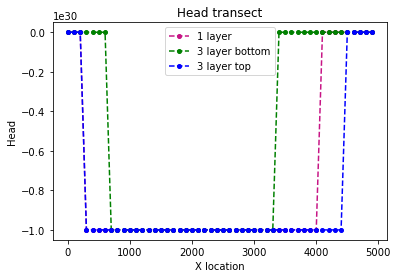

In [757]:
fig4 = plt.figure() 
ax = fig4.add_subplot(1, 1, 1)

x=np.arange(0,5000,100) 
plt.plot(x,head1[0,int(well_row),:],marker='o', color='mediumvioletred', markersize=4, linestyle='--', label="1 layer")
plt.plot(x,head3[2,int(well_row),:],marker='o', color='green', markersize=4, linestyle='--', label="3 layer bottom")
plt.plot(x,head3[0,int(well_row),:],marker='o', color='blue', markersize=4, linestyle='--', label="3 layer top")
plt.title('Head transect')
plt.xlabel('X location')
plt.ylabel('Head')
plt.legend()

# plt.savefig('Head_Transect.png')

### 9.2 1 Layer Head Contours

/opt/miniconda3/envs/gwnew37/lib/python3.7/site-packages/flopy/plot/map.py:823: DeprecationWarning: plot_discharge() has been deprecated and will be replaced in version 3.3.5. Use plot_vector() instead, which should follow after postprocessing.get_specific_discharge()
  DeprecationWarning,
/opt/miniconda3/envs/gwnew37/lib/python3.7/site-packages/flopy/plot/plotutil.py:1634: DeprecationWarning: centered_specific_discharge() has been deprecated and will be removed in version 3.3.5. Use postprocessing.get_specific_discharge() instead.
  DeprecationWarning,


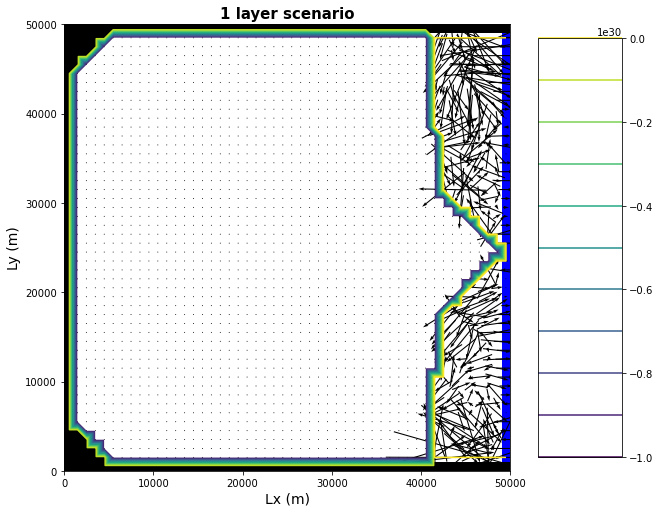

In [758]:
#f, axes = plt.subplots(ncols=1, nrows=2, figsize=(5, 10))
fig3=plt.figure(figsize=(10,10))

modelmap = flopy.plot.PlotMapView(model=m1, layer=0) #use modelmap to attach plot to model
#grid = modelmap.plot_grid() #plot model grid
qm = modelmap.plot_ibound()  
contour_levels = np.linspace(head1[0].min(),head1[0].max(),11) #set contour levels for contouring head
head_contours = modelmap.contour_array(head1, levels=contour_levels) #create head contours
flows = modelmap.plot_discharge(frf1[0], fff1[0], head=head1) #create discharge arrows

#display parameters
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('1 layer scenario', fontsize = 15, fontweight = 'bold')
plt.colorbar(head_contours,aspect=5)
#plt.show(modelmap)
#plt.savefig('WellScenario_vectors.png')   

### 9.3 3 Layer head contours

ValueError: Contour levels must be increasing

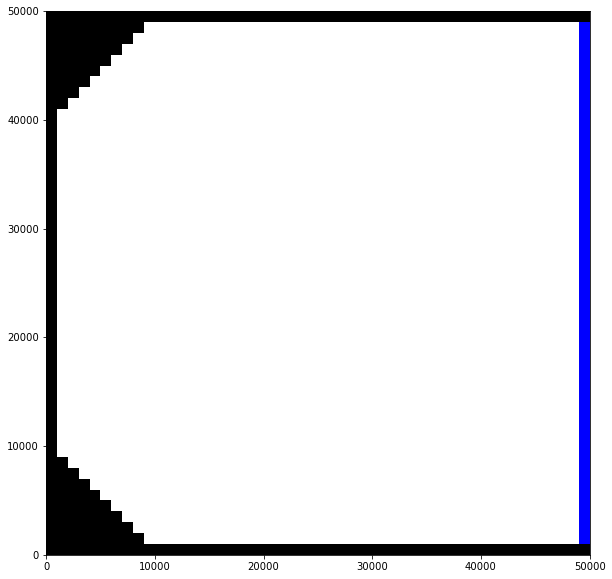

In [759]:
#f, axes = plt.subplots(ncols=1, nrows=2, figsize=(5, 10))
fig3=plt.figure(figsize=(10,10))
# print(fff1[0][0][40])
# print(frf3[0][2][40])

modelmap = flopy.plot.PlotMapView(model=m3, layer=2) #use modelmap to attach plot to model
#grid = modelmap.plot_grid() #plot model grid
qm = modelmap.plot_ibound()  
contour_levels = np.linspace(head3[0][0].min(),head3[0][0].max(),11) #set contour levels for contouring head
head_contours = modelmap.contour_array(head3, levels=contour_levels) #create head contours
flows = modelmap.plot_discharge(frf3[0], fff3[0], head=head3) #create discharge arrows

#display parameters
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('3 layer scenario', fontsize = 15, fontweight = 'bold')
plt.colorbar(head_contours,aspect=5)
#plt.show(modelmap)
#plt.savefig('WellScenario_vectors.png')   